In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Pronósticos de Series de Tiempo
## Ejercicio Práctico Modelo SSA
### Semana 2 a semana 5


Parte I: Solución práctica de un problema de pronóstico a un activo financiero particular. Sigue estas indicaciones:

1. Descarga de Yahoo Finance la serie de precios de cierre del activo META en las fechas: 01-05-2016 al 28-01-2018.

2. Grafica la serie.

3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.

4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.

5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos. En el caso de LSTM diseña y entrena la red con 200 nodos, la función de activación “relu”, epochs=30, función de perdida de ‘mse’, longitud de ventana de 10 yoptimizer='adam'.

6. Aplica cada uno de los modelos MARS, LSTM, RF y SSA a la serie de META. Te puedes apoyar en los tutoriales realizados durante estas semanas.

7. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debescalcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

En este primer paso, importaremos las siguientes librerías para desarrollar este tutorial. Es posible que tengas que instalar las librerías de Rssa. 

In [1]:
#install.packages("dplyr")
#install.packages("Rssa")
library(Rssa)

Loading required package: svd

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘Rssa’


The following object is masked from ‘package:stats’:

    decompose




<a id="7"></a> <br>
### 3. Funciones Manuales
Definimos algunas funciones complemetarias al paquete de Rssa que ayudan al proceso de selección para la recosntrucción.

In [2]:
##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

In [3]:
##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

In [4]:
###W-correlation
W.corr<-function(Yt,L, groups){
  m<-length(groups); w.corr<-diag(m)
  N<-length(Yt)
  w<-((N+1)-abs((N+1)/2-L)-abs((N+1)/2-1:N)-
    abs(abs((N+1)/2-L)-abs((N+1)/2-1:N)))/2
wcorr<-function(i,j){
  Y1<-SSA.Rec(Yt,L,groups[[i]])$Approximation
  Y2<-SSA.Rec(Yt,L,groups[[j]])$Approximation
  sum(w*Y1*Y2)/sqrt(sum(w*Y1^2)*sum(w*Y2^2))}
for (i in 1:(m-1)){
  for (j in (i+1):m){
    w.corr[i,j]=w.corr[j,i]=wcorr(i,j)}}
rownames(w.corr)<-colnames(w.corr)<-groups
w.corr
}

In [5]:
###Plotting Images w.corr
Plt.Img<-function(x){
  min<-min(x)
  max<-max(x)
  yLabels<-rownames(x)
  xLabels<-colnames(x)
  if( is.null (xLabels)){
    xLabels <- c(1:ncol(x))
  }
  if (is.null(yLabels)){
    yLabels <- c(1:nrow(x))
  }
  layout(matrix(data=c(1,2), nrow=1, ncol=2),
         widths=c(4,1), heights=c(1,1))
  ColorRamp<-gray( seq(1,0, length=20))
  ColorLevels<-seq(min, max, length=length(ColorRamp))
                  par(mar=c(3,5,2.5,2))
                  image(1:length(xLabels), 1:length(yLabels),
                        t(x), col=colorRamp, xlab="",
                        ylab = "", axes=FALSE, zlim=c(min, max))
                  title(main=c("Image Plot"))
                  axis(BELOW<-1, at=1:length(xLabels),
                       labels=xLabels, cex.axis=0.7)
                  axis(LEFT<-2, at=1:length(yLabels),
                       labels=yLabels, las=HORIZONTAL<-1,
                       cex.axis=0.7)
                  box()
                  par(mar=c(3,2.5, 2.5,2))
                  image(1, ColorLevels,
                        matrix(data=ColorLevels, ncol=length(ColorLevels), nrow=1),
                        col=colorRamp,
                        xlab="", ylab="",
                        xaxt="n")
                  layout(1)
}

In [6]:
##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")
  title(ylab="Log.Singular Values")}


## Importar los datos


In [12]:
#Importación de librerias requeridas:
library(Rssa)
library(TTR)
library(quantmod)
library(xts)
library(tseries)
#library(TSA)
library(ggplot2)
library(PerformanceAnalytics) ##vamos a ver, rendimientos
library(Metrics)
library(tseries)


Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend



Attaching package: ‘Metrics’


The following objects are masked from ‘package:caret’:

    precision, recall


The following object is masked from ‘package:forecast’:

    accuracy




In [50]:
options(digits=3)
options(warn=-1)

#Obtención DATOS:
META<-getSymbols("META", from="2016-05-01", to="2018-01-28",auto.assign = FALSE)
META<-na.omit(META)
META<-META[,4]
head(META)
colnames(META)<-c("META")

           META.Close
2016-05-02        119
2016-05-03        117
2016-05-04        118
2016-05-05        118
2016-05-06        119
2016-05-09        119

In [51]:
##Juntar los datos y renombrarlos:
Pr<-merge.xts(META) %>% na.omit()
colnames(Pr) <- c("META")

##Serie tiempo, grafica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c(start, end))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

HTML widgets cannot be represented in plain text (need html)

NULL

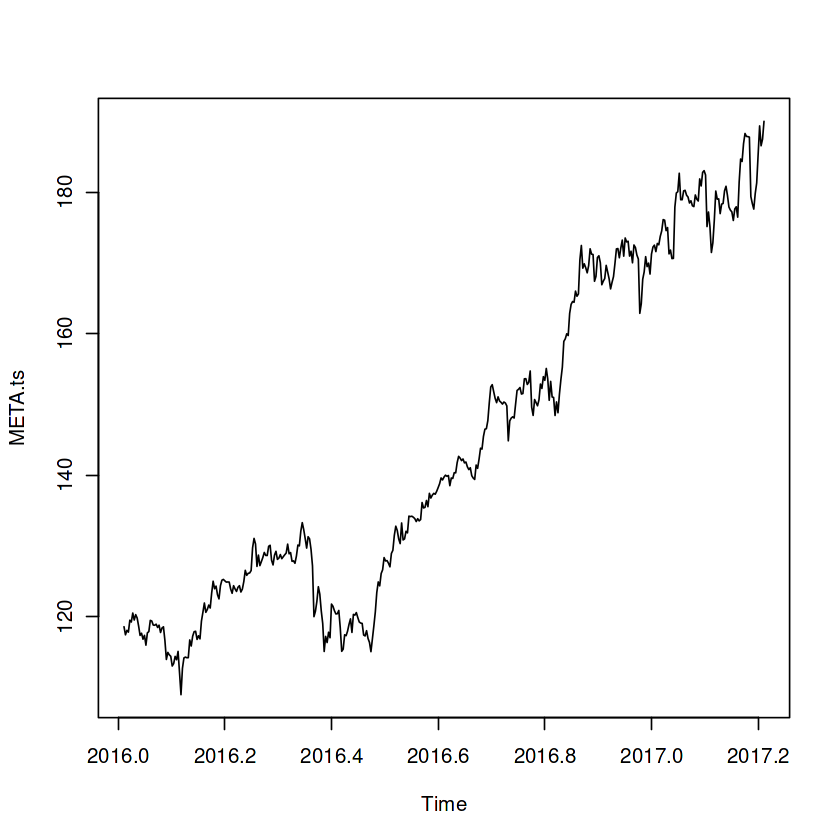

In [54]:
# Un paso importante que hay que hacer, es pasar los datos de formato xts a ts, que es el formato que emplea SSA. para ello, pasamos primero a data frame
# y luego a ts.
META <- data.frame(date=index(META), coredata(META))
META1<-META$META
##pasamos a ts
META.ts<-ts(META1, start=c(2016,05), frequency = 365)
plot(META.ts)

In [55]:
length(META.ts)

[1] 439

In [58]:
#Una vez creada la ventana h, generamos los conjuntos de entrenamiento y prueba.
train<-META.ts[1:(length(META.ts)-h)]
test<-META.ts[(length(META.ts)-h+1):length(META.ts)]
tail(train)
head(test)
str(test)

train.ts=ts(train,start=c(2016,05), frequency = 365)

[1] 180 181 180 178 177 177

[1] 176 178 178 176 181 185

 num [1:22] 176 178 178 176 181 ...


#### Pasos 1 y 2
En estos pasos, aplicamos la función de ssa() a la serie en formato ts y procedemos a la selección para la recosntrucción.

In [59]:
##SSA embeding y separación:
s1<-ssa(train.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.
s1


Call:
ssa(x = train.ts)

Series length: 417,	Window length: 209,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.0864 MiB

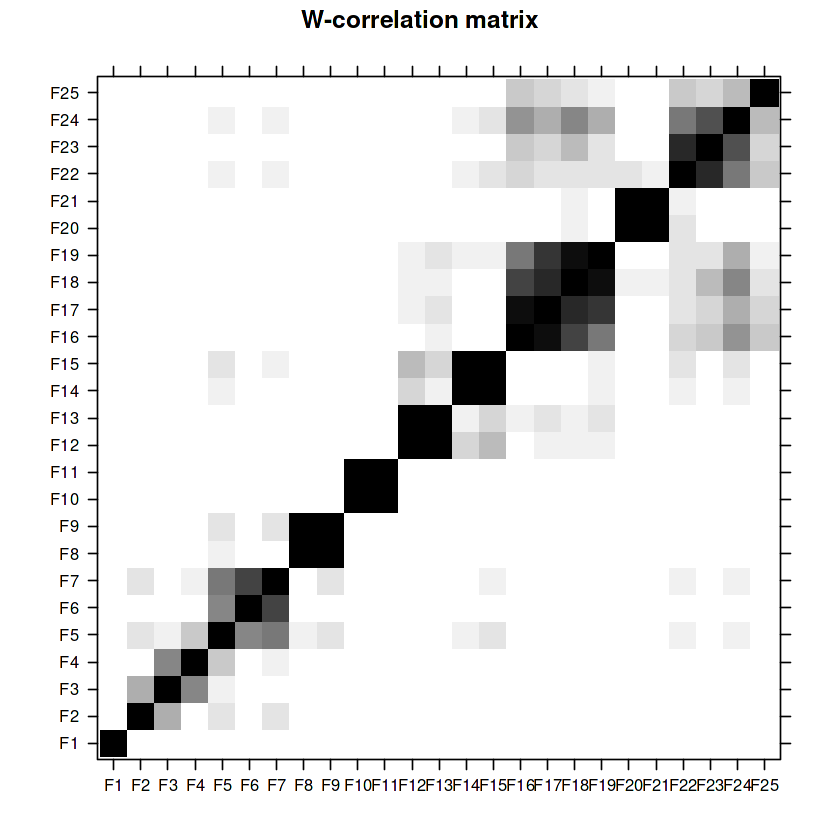

In [60]:
##Reconstrucción: empleamos las herramientas visuales para la selección.
wplot<-wcor(s1, group=1:25)
plot(wplot)

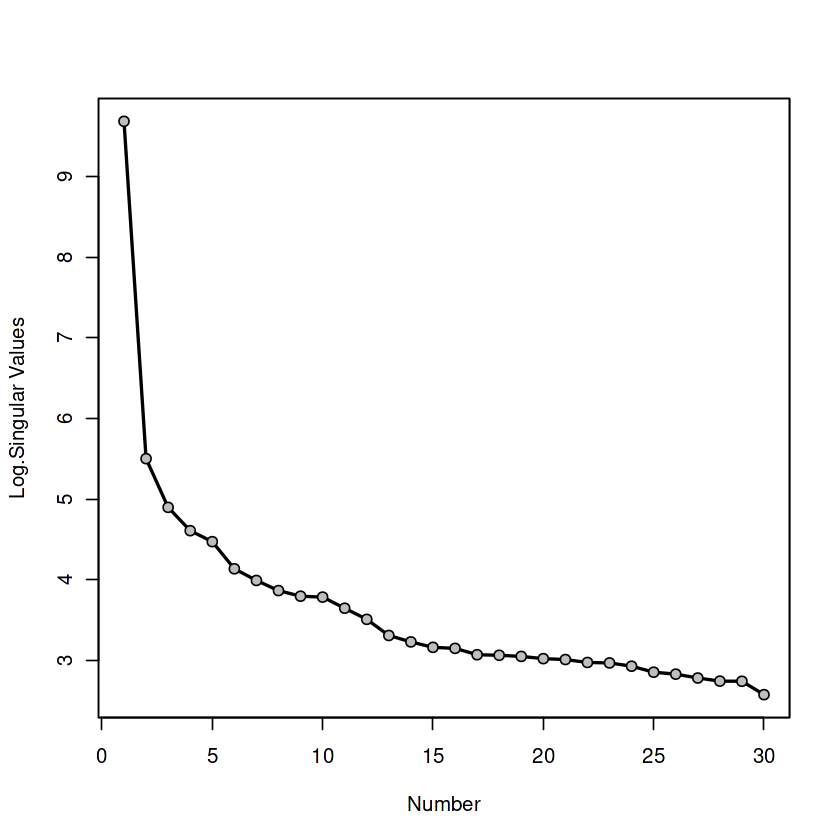

In [62]:
#Tambien generamos la scree-plot.
Sing.plt(META.ts, 30)

Como vemos en los gráficos anteriores, el primer vector aporta la mayor de la variación, y hasta el octavo se observa una separación con los vectores no separables, y en la scree plot, un decaimiento del log-valores singulares. Procedemos con las gráficas de vectores singulares y en pares.

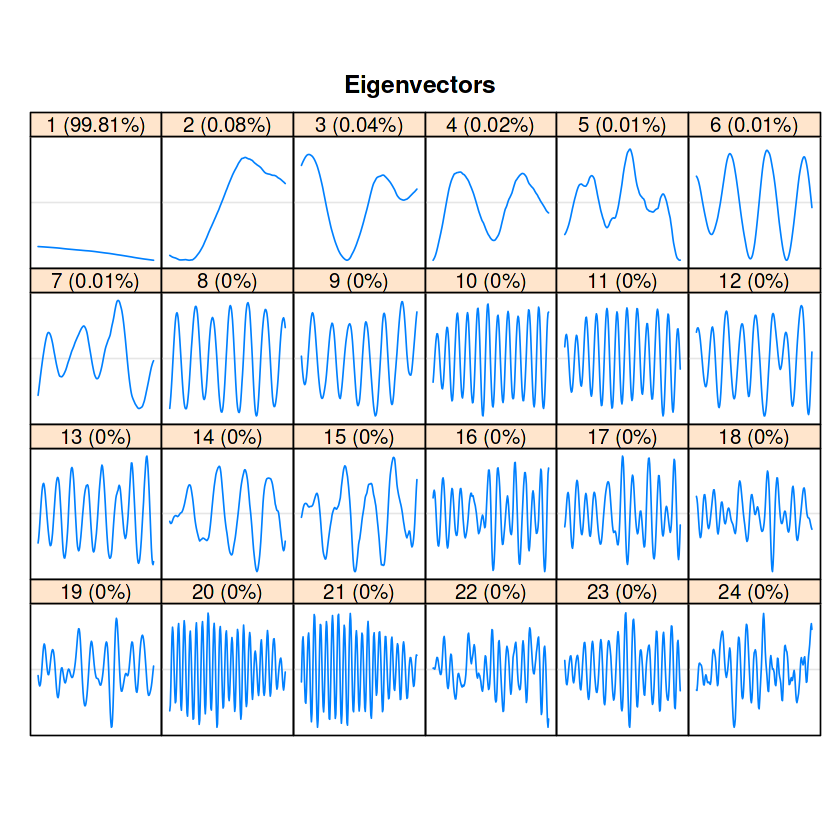

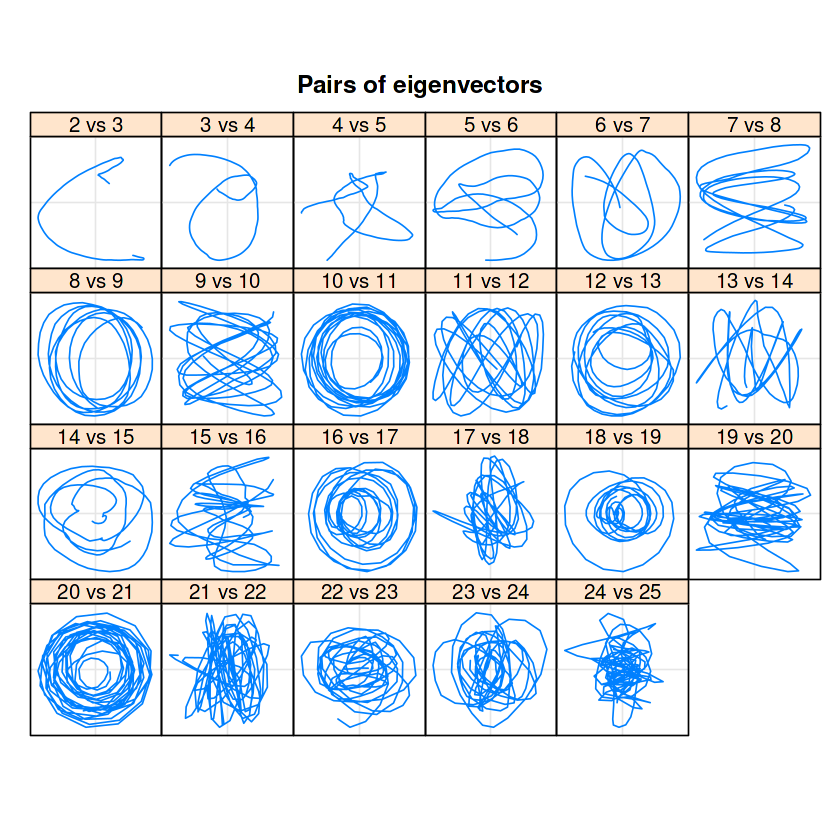

In [63]:
###Gráficas componentes 1D (compoente por componente) y la 2D (pares formen poligonos regulares : estables)
plot(s1, type="vectors", idx=1:24)
plot(s1, type= "paired", idx=2:24, plot.contrib = FALSE)

A partir de los resultados anteriores, podemos proponer que los vectores 1:5 y 7 son candidatos para los vectores que comprenden la tendencia; mientras que los pares de vectores 8 y 9, 10 y 11, 16 y 17, 20 y 21 representan la estacionalidad.

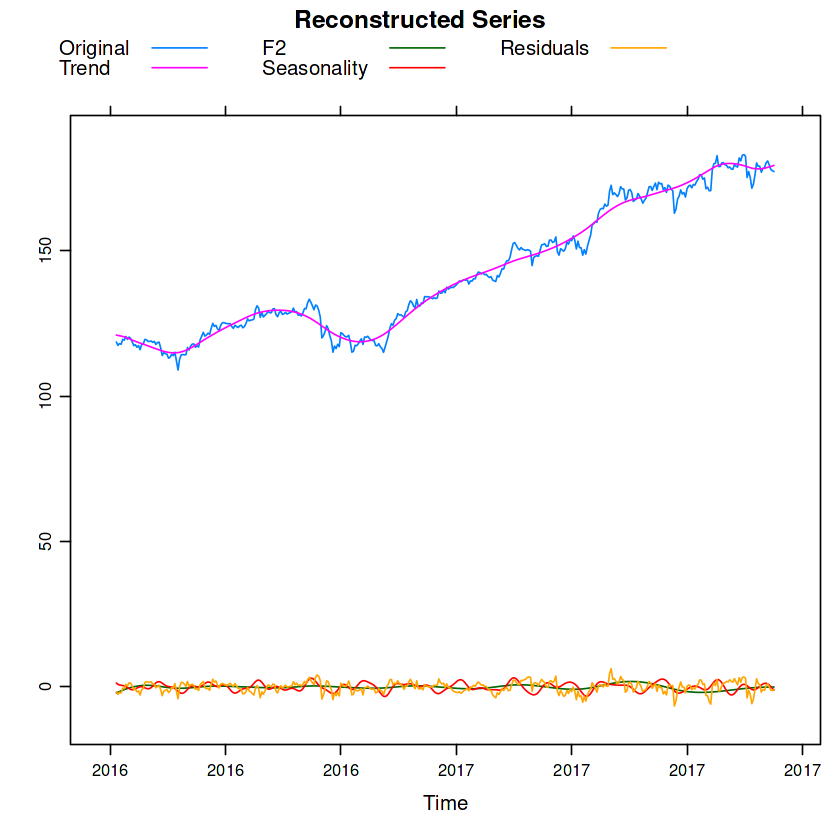

In [64]:
##Fase recontrucción:
r=reconstruct(s1, groups = list(Trend=1:5,7, Seasonality=c(8:9,10:11,16:17,20:21)))
plot(r, add.residuals=TRUE, add.original=TRUE, plot.method="xyplot",
     superpose=TRUE, auto.key=list(columns=4))

In [75]:
#Generamos el pronóstico señalando los tripletes de la reconstrucción.
pronostico1<-forecast(s1, groups = list(c(1:5,7,8:11,16:17,20:21)), len=h, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )

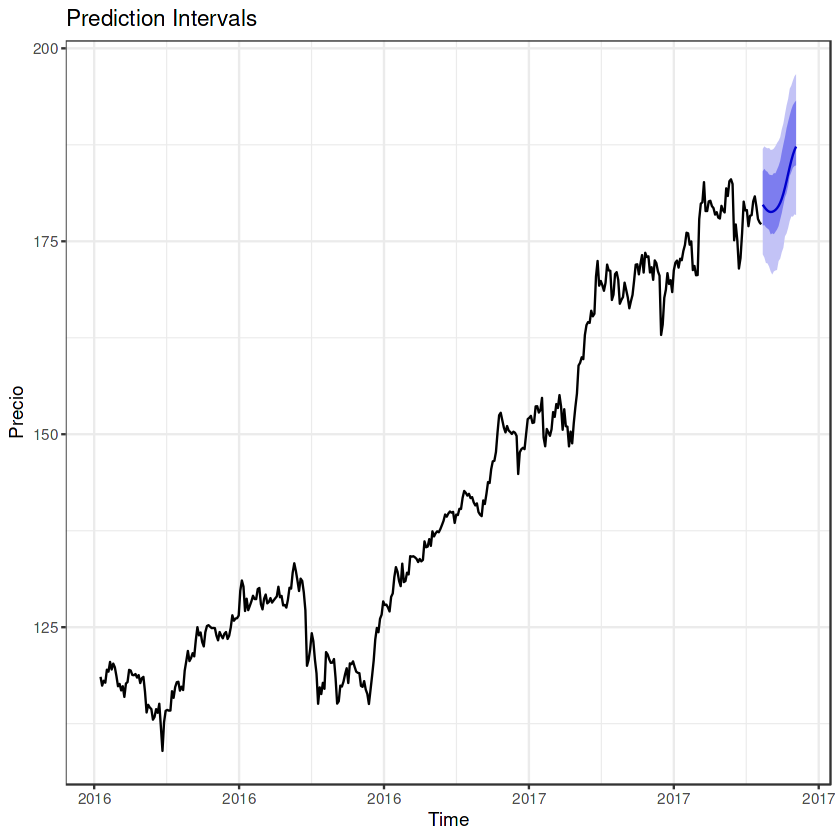

In [76]:
# Graficamos el pronóstico.
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

In [ ]:
# Graficamos el pronóstico.
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

In [67]:
pred<-pronostico1$mean
pred

A Time Series:
 [1] 180 179 179 179 179 179 179 179 179 179 180 180 181 181 182 183 184 185 185
[20] 186 187 187

In [71]:
###Cálculo error MAPE, RMSE
library(Metrics)
RMSE1<-rmse(test,pred)
RMSE1
MAE1<-mae(test, pred)
MAE1

[1] 4.83

[1] 3.96

Igualmente, podemos revisar las características de la serie mediante la función de tsfeatures. Como podemos ver, el SSA es un buen método muy versátil para series con niveles de linealidad altos y niveles de entropía bajos. Esto a pesar que el método es más recomendado para las series con bajas linealidades y altos niveles de entropía.

In [72]:
library(tsfeatures)
tsfeatures(train.ts)

frequency,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,entropy,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
365,1,365,0.99,1.74e-09,19.2,4.39,0.735,1.04,0.0934,0.993,9.24,-0.0155,0.0344,-0.495,0.282,-0.236


*Elaborado por Rebeca Gamboa para el curso de Pronósticos, MIAD*